### Setup

In [1]:
# Main
import numpy as np
import pandas as pd
import datetime as dt

# Modeling
import statsmodels.api as sm

# Unit root
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS, ZivotAndrews
from quantileADF import QAR, comparisonPlot

# Tests and function
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.regression.linear_model import OLS

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup
repoUrl = 'https://raw.githubusercontent.com/vlad-yeghiazaryan/QADF/master/data/'
broadREERsUrl = repoUrl + 'broadREERs.csv'
narrowREERsUrl = repoUrl + 'narrowREERs.csv'
pd.io.formats.excel.ExcelFormatter.header_style = None

In [2]:
def univariate(data):
    univariateTests = pd.DataFrame()
    univariateTests['ADF'] = data.apply(lambda col: ADF(col).pvalue)
    univariateTests['DFGLS'] = data.apply(lambda col: DFGLS(col).pvalue)
    univariateTests['PP'] = data.apply(lambda col: PhillipsPerron(col).pvalue)
    univariateTests['KPSS'] = data.apply(lambda col: KPSS(col).pvalue)
    univariateTests['ZA'] = data.apply(lambda col: ZivotAndrews(col).pvalue)
    return univariateTests.applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

In [3]:
def comparisonPlots(data,fileName='changesOverQuantiles'):
    figs = []
    for index, pos in enumerate(range(0, data.shape[1], 3)):
        columns = data.columns[pos: min(data.shape[1], pos+3)]
        figsize = (len(columns)*5, 6)
        countries = data[columns]
        fig = comparisonPlot(countries, figsize=figsize)
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{index+1}', dpi = 150)
    return figs

In [4]:
def markovRegimeSwitchingPlots(data, fileName='regimeSwitchingProbabilities'):
    figs = []
    for i, pos in enumerate(range(0, data.shape[1], 2)):
        columns = data.columns[pos: min(data.shape[1], pos+2)]
        figsize = (len(columns)*5, 6)
        fig = plt.figure()
        for index, country in enumerate(columns):
            mainModel = QAR(data[country])
            ax = fig.add_subplot(1, len(columns), index+1)
            mod = sm.tsa.MarkovRegression(mainModel.y, trend='c', k_regimes=2, order=2, freq='MS').fit()
            ylabel = 'Probability of being in the high regime'
            title = mainModel.name
            ax = mod.smoothed_marginal_probabilities[1].plot(title=title,ylabel=ylabel, figsize=(12,3))
            ax.axvline('2015-1-1', color='black')
            trans = ax.get_xaxis_transform()
            plt.text('2015-1-1', -.1, 'EAEU', transform=trans, weight='bold')
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{i+1}', dpi = 150)
    return figs

In [5]:
def saveToExcel(dataframe, path, def_properties={}):
    # Setup
    writer = pd.ExcelWriter(path)
    dataframe.style.set_properties(**def_properties).to_excel(writer)

    def dummyCriteria(f): return {'type': 'cell',
                                  'criteria': '!=', 'value': 0, 'format': f}

    def excel_colnum_string(n):
        string = ""
        while n > 0:
            n, remainder = divmod(n - 1, 26)
            string = chr(65 + remainder) + string
        return string

    # Accessing
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    colLetter = excel_colnum_string(dataframe.shape[1]+1)
    tableRange = 'A1:'+colLetter+str(dataframe.shape[0]+1)
    header = 'A1:'+colLetter+'1'
    footer = 'A'+str(dataframe.shape[0]+1) + \
        ':'+colLetter+str(dataframe.shape[0]+1)
    indexCol = 'A1:'+'A'+str(dataframe.shape[0]+1)

    # Styles
    defaultFormat = {'font_name': 'Calibri', 'font_size': 8,
                     'bg_color': '#FFFFFF',
                     'align': 'center',
                     'valign': 'vcenter',
                     'border': 0,
                     'shrink': True,
                     'text_wrap': True}
    columnFormat = workbook.add_format(defaultFormat)
    columnFormat.set_font_size(8)
    headerFormat = workbook.add_format(
        {**defaultFormat, **{'top': 5, 'bottom': 2, 'bold': True}})
    footerFormat = workbook.add_format({**defaultFormat, **{'bottom': 5}})
    indexFormat = workbook.add_format({**defaultFormat, **{'align': 'left'}})

    # Applying Styles
    worksheet.conditional_format(tableRange, dummyCriteria(columnFormat))
    worksheet.conditional_format(header, dummyCriteria(headerFormat))
    worksheet.conditional_format(footer, dummyCriteria(footerFormat))
    worksheet.conditional_format(indexCol, dummyCriteria(indexFormat))
    writer.save()
    print('Table saved to:', path)

In [6]:
broadREERs = pd.read_csv(broadREERsUrl, index_col=0, parse_dates=True)
narrowREERs = pd.read_csv(narrowREERsUrl, index_col=0, parse_dates=True)

# Extracting country information
countries = ['Armenia', 'Belarus', 'Kazakhstan', 'Kyrgyz Republic',
             'Moldova', 'Russian Federation', 'Tajikistan', 'Ukraine']

startDate = '2000-01-01'
startDateWithoutTaj = '1995-01-01'

data = broadREERs[countries].loc[startDate:]

# Changing data
dataLogs = data.apply(np.log, axis=1)
dataPtC = dataLogs.diff()[1:]

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2000-01-01 to 2020-11-01
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Armenia             251 non-null    float64
 1   Belarus             251 non-null    float64
 2   Kazakhstan          251 non-null    float64
 3   Kyrgyz Republic     251 non-null    float64
 4   Moldova             251 non-null    float64
 5   Russian Federation  251 non-null    float64
 6   Tajikistan          251 non-null    float64
 7   Ukraine             251 non-null    float64
dtypes: float64(8)
memory usage: 17.6 KB


### REERs of EAEU countries

In [7]:
# renormalize REERs at 2000q1 = 100
data = 100*data/data.iloc[0,:]

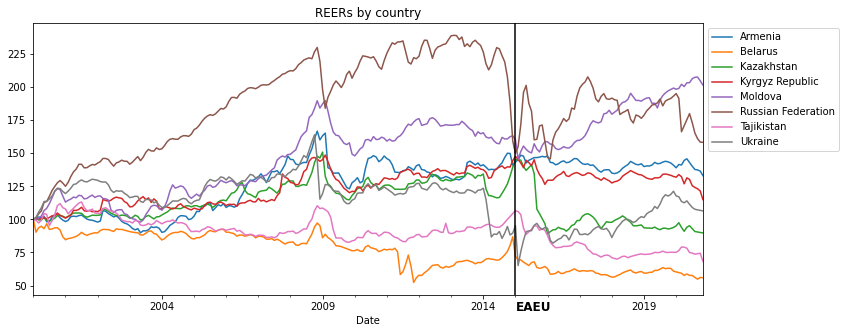

In [8]:
ax = data.plot(kind='line', subplots=False, sharey=True, 
          layout=(1,1), figsize=(12, 5), title='REERs by country', legend=False)

ax.legend(bbox_to_anchor=(1, 1), loc='best')
mark = '2015'
ax.axvline(mark+'-1-1', color='black')
ax.text(mark+'-1-1', -0.06, 'EAEU', transform=ax.get_xaxis_transform(), weight='bold', fontsize='large')

plt.savefig('Outputs/REERsByCountry', dpi = 150, bbox_inches='tight')
plt.show()

In [9]:
colNames = {
    'count': 'N',
    'mean': 'Mean',
    'std': 'St.dev.',
    'min': 'Min.',
    'max': 'Max.',
    '50%': 'Median',
}
tests = ['Jarque-Bera', 'Jarque-Bera (P-value)', 'Skewness', 'Kurtosis']
include = ['N', 'Mean', 'Median', 'Min.', 'Max.', 'St.dev.',
           'Skewness', 'Kurtosis', 'Jarque-Bera', 'Jarque-Bera (P-value)']

# Summary Setup
summaryStatistics = data.describe().T
JB = data.apply(jarque_bera).T
summaryStatistics[tests] = JB
summaryStatistics.rename(columns=colNames, inplace=True)
summaryTable = summaryStatistics[include].applymap(
    lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)
summaryTable.index.name = 'Countries'
# saveToExcel(summaryTable, path="Outputs/summaryStatistics.xlsx", def_properties={'text-align': 'center'})
summaryTable

,N,Mean,Median,Min.,Max.,St.dev.,Skewness,Kurtosis,Jarque-Bera,Jarque-Bera (P-value)
Countries,,,,,,,,,,
Armenia,251,127.893,136.073,89.885,166.711,19.203,-0.587,1.967,25.576,0.000
Belarus,251,76.005,77.465,52.363,100.000,12.980,-0.112,1.465,25.185,0.000
Kazakhstan,251,112.964,110.288,89.113,150.891,14.922,0.288,1.980,14.334,0.001
Kyrgyz Republic,251,124.777,129.577,100,148.616,12.651,-0.282,1.842,17.350,0.000
Moldova,251,151.165,157.522,98.007,207.601,29.105,-0.105,1.949,12.008,0.002
Russian Federation,251,186.178,189.951,100,239.107,33.331,-0.349,2.303,10.171,0.006
Tajikistan,251,90.412,90.907,68.353,113.193,10.521,-0.078,2.382,4.249,0.119
Ukraine,251,115.008,119.114,65.136,163.976,16.003,-0.365,2.993,5.561,0.062


In [10]:
univariateTable = univariate(dataLogs)
univariateTable.index.name = 'Countries'
# saveToExcel(univariateTable, path='Outputs/univariateTests.xlsx')
univariateTable

,ADF,DFGLS,PP,KPSS,ZA
Countries,,,,,
Armenia,0.450,0.480,0.491,0.000,0.076
Belarus,0.812,0.857,0.656,0.000,0.153
Kazakhstan,0.329,0.098,0.609,0.035,0.000
Kyrgyz Republic,0.221,0.400,0.222,0.000,0.540
Moldova,0.541,0.856,0.582,0.000,0.745
Russian Federation,0.030,0.617,0.024,0.003,0.327
Tajikistan,0.578,0.427,0.795,0.000,0.169
Ukraine,0.301,0.117,0.182,0.002,0.168


/usr/local/lib/python3.8/dist-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


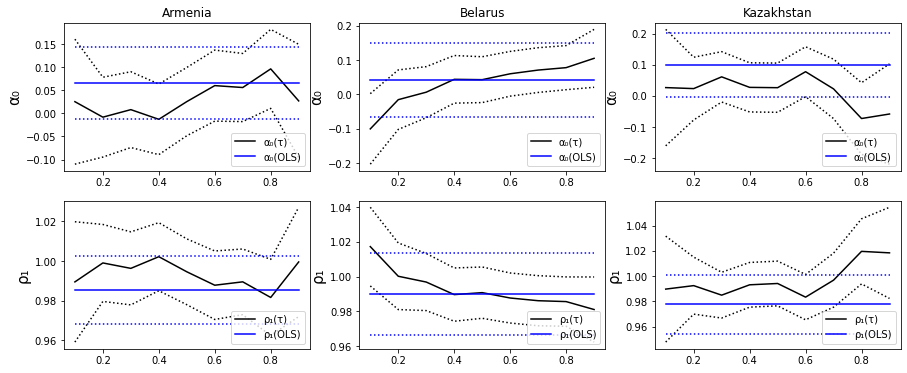

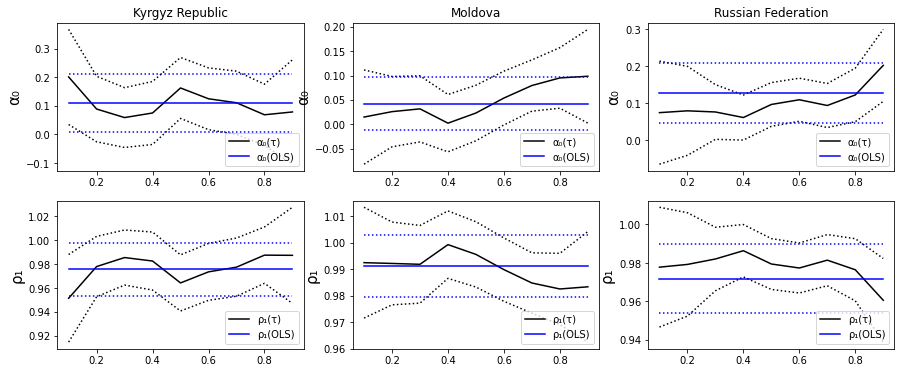

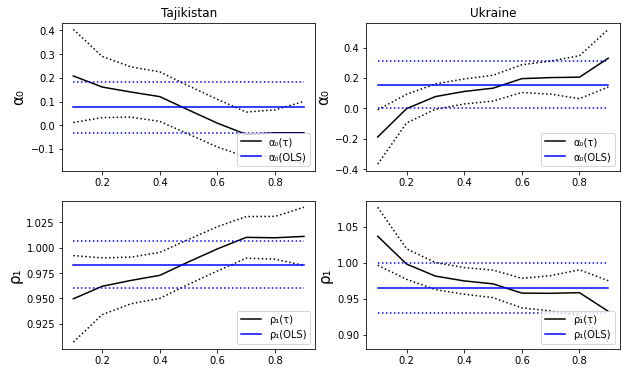

In [11]:
comparisonPlots(dataLogs)
plt.show()

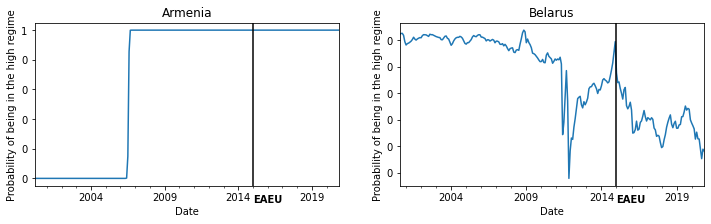

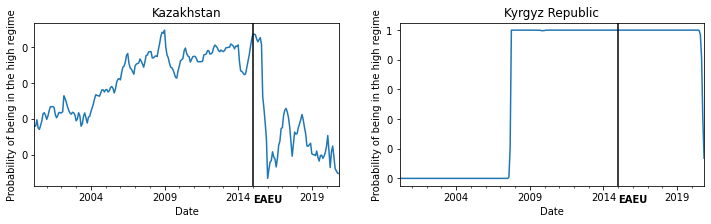

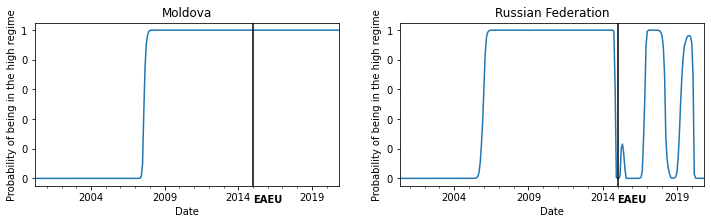

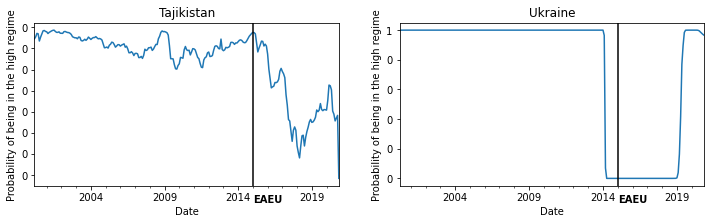

In [12]:
markovRegimeSwitchingPlots(data)
plt.show()

In [13]:
def getCorrespQuant(col, value=100):
    if type(value) != int:
        value = value[col.name]
    return (abs(col-value).idxmin())

data100 = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[100]).T
data100.name = 'REER=100'

dataEAEU = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.mean()]).T
dataEAEU.name = 'REER=Mean (entire period)'

dataBefore = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.loc[:'2015-1-1'].mean()]).T
dataBefore.name = 'REER=Mean (before EAEU)'

dataAfter = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.loc['2015-1-1':].mean()]).T
dataAfter.name = 'REER=Mean (after EAEU)'

targets = {
    'Armenia': 'N/A',
    'Belarus': 'N/A',
    'Kazakhstan': 'N/A',
    'Kyrgyz Republic': '0.1,0.5',
    'Moldova': '0.7,0.8',
    'Russian Federation': '0.5-0.9*',
    'Tajikistan': '0.1-0.4',
    'Ukraine': '0.4-0.9*'
}

before_targets = {
    'Armenia': 'N/A',
    'Belarus': '0.5-0.9*',
    'Kazakhstan': '0.2',
    'Kyrgyz Republic': '0.1',
    'Moldova': '0.6, 0.8',
    'Russian Federation': 'N/A',
    'Tajikistan': '0.1-0.4*',
    'Ukraine': '0.4-0.7*'
}

after_targets = {
    'Armenia': 'N/A',
    'Belarus': 'N/A',
    'Kazakhstan': '0.1-0.4*',
    'Kyrgyz Republic': '0.7,0.8*',
    'Moldova': '0.9',
    'Russian Federation': '0.5-0.9*',
    'Tajikistan': '0.2-0.7',
    'Ukraine': 'N/A'
}

dataTargets = pd.Series(targets.values(), index=targets.keys(), name='Mean Reversion (entire period)')
EAEU_beforeTargets = pd.Series(before_targets.values(), index=before_targets.keys(), name='Mean Reversion (before EAEU)')
EAEU_afterTargets = pd.Series(after_targets.values(), index=after_targets.keys(), name='Mean Reversion (after EAEU)')

# Constructing the table
meanBehavior = pd.concat([data100, dataEAEU, dataBefore, dataAfter, 
                          EAEU_beforeTargets, EAEU_afterTargets, dataTargets], axis=1)
meanBehavior.index.name = 'Countries'
# saveToExcel(meanBehavior, path='Outputs/meanBehavior.xlsx')
meanBehavior

,REER=100,REER=Mean (entire period),REER=Mean (before EAEU),REER=Mean (after EAEU),Mean Reversion (before EAEU),Mean Reversion (after EAEU),Mean Reversion (entire period)
Countries,,,,,,,
Armenia,0.13,0.34,0.32,0.73,N/A,N/A,N/A
Belarus,0.99,0.46,0.57,0.19,0.5-0.9*,N/A,N/A
Kazakhstan,0.23,0.53,0.58,0.25,0.2,0.1-0.4*,N/A
Kyrgyz Republic,0.10,0.42,0.39,0.66,0.1,"0.7,0.8*","0.1,0.5"
Moldova,0.10,0.41,0.36,0.82,"0.6, 0.8",0.9,"0.7,0.8"
Russian Federation,0.10,0.47,0.48,0.41,N/A,0.5-0.9*,0.5-0.9*
Tajikistan,0.84,0.47,0.68,0.18,0.1-0.4*,0.2-0.7,0.1-0.4
Ukraine,0.22,0.41,0.62,0.20,0.4-0.7*,N/A,0.4-0.9*


### Covergence in subsamples

In [14]:
adf = ADF(dataLogs['Armenia'])
adf.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.988
Date:                Thu, 24 Jun 2021   Prob (F-statistic):            0.00752
Time:                        19:50:07   Log-Likelihood:                 596.91
No. Observations:                 249   AIC:                            -1188.
Df Residuals:                     246   BIC:                            -1177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0147      0.009     -1.664      0.097      -0.032       0.003
Diff.L1        0.1726      0.063      2.753      0.006       0.049       0.296
const          0.0662      0.039      1.686      0.093      -0.011       0.144
==============================================================================
Omnibus:                      128.453   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2270.192
Skew:                          -1.583   Prob(JB):                         0.00
Kurtosis:                      17.450   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
adf.summary()

Test Statistic,-1.664
P-value,0.450
Lags,1


#### Standard ADF test

In [16]:
# This replicates the results above with the ADF class
d_y = dataLogs['Armenia'].diff()
y_1 = dataLogs[['Armenia']].shift(1)
d_y_1 = dataLogs['Armenia'].diff(1).shift(1)
Res = OLS(d_y[2:],exog=sm.add_constant((y_1.join(d_y_1,rsuffix='_d'))[2:])).fit()
Res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.988
Date:                Thu, 24 Jun 2021   Prob (F-statistic):            0.00752
Time:                        19:50:07   Log-Likelihood:                 596.91
No. Observations:                 249   AIC:                            -1188.
Df Residuals:                     246   BIC:                            -1177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0662      0.039      1.686      0.093      -0.011       0.144
Armenia       -0.0147      0.009     -1.664      0.097      -0.032       0.003
Armenia_d      0.1726      0.063      2.753      0.006       0.049       0.296
==============================================================================
Omnibus:                      128.453   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2270.192
Skew:                          -1.583   Prob(JB):                         0.00
Kurtosis:                      17.450   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ADF test with dummies

In [17]:
# ADF test with pre- and post-EAEU dummies
d_y = dataLogs['Armenia'].diff()
y_1_pre = dataLogs[['Armenia']].apply(lambda x: x*(dataLogs.index < dt.datetime(2015,1,1))).shift(1)
y_1_post = dataLogs[['Armenia']].apply(lambda x: x*(dataLogs.index >= dt.datetime(2015,1,1))).shift(1)
d_y_1 = dataLogs['Armenia'].diff(1).shift(1)
Res = OLS(d_y[2:],exog=sm.add_constant((y_1_pre.join(y_1_post,lsuffix='_pre',rsuffix='_post').join(d_y_1,rsuffix='_d'))[2:])).fit()
Res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.314
Date:                Thu, 24 Jun 2021   Prob (F-statistic):             0.0207
Time:                        19:50:07   Log-Likelihood:                 596.92
No. Observations:                 249   AIC:                            -1186.
Df Residuals:                     245   BIC:                            -1172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0646      0.044      1.474      0.142      -0.022       0.151
Armenia_pre     -0.0143      0.010     -1.438      0.152      -0.034       0.005
Armenia_post    -0.0144      0.010     -1.494      0.137      -0.033       0.005
Armenia          0.1722      0.063      2.734      0.007       0.048       0.296
==============================================================================
Omnibus:                      129.117   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2289.270
Skew:                          -1.594   Prob(JB):                         0.00
Kurtosis:                      17.508   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# ADF test with post-EAEU dummy
d_y = dataLogs['Armenia'].diff()
y_1 = dataLogs[['Armenia']].shift(1)
y_1_post = dataLogs[['Armenia']].apply(lambda x: x*(dataLogs.index >= dt.datetime(2015,1,1))).shift(1)
d_y_1 = dataLogs['Armenia'].diff(1).shift(1)
Res = OLS(d_y[2:],exog=sm.add_constant((y_1.join(y_1_post,rsuffix='_post').join(d_y_1,rsuffix='_d'))[2:])).fit()
Res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.314
Date:                Thu, 24 Jun 2021   Prob (F-statistic):             0.0207
Time:                        19:50:07   Log-Likelihood:                 596.92
No. Observations:                 249   AIC:                            -1186.
Df Residuals:                     245   BIC:                            -1172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0646      0.044      1.474      0.142      -0.022       0.151
Armenia         -0.0143      0.010     -1.438      0.152      -0.034       0.005
Armenia_post -6.512e-05      0.001     -0.084      0.933      -0.002       0.001
Armenia_d        0.1722      0.063      2.734      0.007       0.048       0.296
==============================================================================
Omnibus:                      129.117   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2289.270
Skew:                          -1.594   Prob(JB):                         0.00
Kurtosis:                      17.508   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ADF test results

##### Standard: t-stat = -1.664, p-value = 0.450
##### Pre-EAEU: t-stat = -1.438
##### Post-EAEU: t-stat = -1.494
##### Diff: t-stat = -0.084

### Capturing Convergence

In [19]:
# ETSModel
# VAR, SVAR, VECM
# ?